Import necessary packages

In [15]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

from tqdm import tqdm
import time

Let's check how many GPUs are available for training:

In [16]:
cuda_available = torch.cuda.is_available()
nb_devices = torch.cuda.device_count()
print(f"Can I run on CUDA? {'Yes' if cuda_available else 'No'}. You have {nb_devices} CUDA device{'s' if nb_devices > 1 else ''} available")
torch.cuda.set_device(0)

Can I run on CUDA? Yes. You have 2 CUDA devices available


Set hyperparameters value

In [17]:
# number of subprocesses to use for data loading
num_workers = 4
# number of epochs
n_epochs = 10
# learning rate
learning_rate = 0.01
# We still need to specify the device, as the model will just be replicated on the GPUs
devices_parameters = [{
    "parallel": True,
    "device": "cuda:0",
    "id": None,
    "batch_size": 40 # double the batch_size as it will be split among the 2 GPUs
}, {
    "parallel": False,
    "device": "cuda:0",
    "id": 0,
    "batch_size": 20
}, {
    "parallel": False,
    "device": "cuda:1",
    "id": 1,
    "batch_size": 20
}]

Define the CNN architecture

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


Let's create a simple timing decorator

In [19]:
GPU_total_time = []

def timing(f):
    def wrap(*args, **kwargs):
        start = time.time()
        cb = f(*args, **kwargs)
        stop = time.time()
        GPU_total_time.append(stop - start)
        return cb
    return wrap

Set the train function

In [20]:
@timing
def train(device, batch_size):
    # Setup the training data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
    
    training_times = []
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        
        # train the model
        model.train()
        start = time.time()
        for i, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
        stop = time.time()
        training_times.append(stop - start)
        
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f}")
    return training_times
        

In [21]:
all_devices_timing = []

for i, devparam in enumerate(devices_parameters):
    model = Net()
    device, batch_size = devparam["device"], devparam["batch_size"]
    if devparam["id"] is not None:
        torch.cuda.set_device(devparam["id"])
        device_name = torch.cuda.get_device_name()
        print(f"Running on device: {device_name}")
    if devparam["parallel"]:
        model = nn.DataParallel(model, device_ids=[0,1])
        device_name = "parallel GPUs"
        print("Running in parallel")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_time = train(device, batch_size)
    all_devices_timing.append({
        "device": device_name,
        "train_time": train_time
    })

c:\Users\Admin\Anaconda3\envs\torch-36\lib\site-packages\torch\nn\parallel\data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Running in parallel
Files already downloaded and verified


  0%|          | 0/1250 [00:00<?, ?it/s]c:\Users\Admin\Anaconda3\envs\torch-36\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
100%|██████████| 1250/1250 [00:17<00:00, 70.50it/s] 


Epoch: 1 	Training Loss: 2.161319


100%|██████████| 1250/1250 [00:18<00:00, 67.98it/s] 


Epoch: 2 	Training Loss: 1.739686


100%|██████████| 1250/1250 [00:20<00:00, 60.65it/s] 


Epoch: 3 	Training Loss: 1.533593


100%|██████████| 1250/1250 [00:17<00:00, 71.30it/s] 


Epoch: 4 	Training Loss: 1.416018


100%|██████████| 1250/1250 [00:19<00:00, 64.11it/s] 


Epoch: 5 	Training Loss: 1.322448


100%|██████████| 1250/1250 [00:20<00:00, 61.13it/s] 


Epoch: 6 	Training Loss: 1.249446


100%|██████████| 1250/1250 [00:17<00:00, 69.87it/s] 


Epoch: 7 	Training Loss: 1.185416


100%|██████████| 1250/1250 [00:17<00:00, 73.40it/s] 


Epoch: 8 	Training Loss: 1.126867


100%|██████████| 1250/1250 [00:16<00:00, 75.05it/s] 


Epoch: 9 	Training Loss: 1.071387


100%|██████████| 1250/1250 [00:16<00:00, 75.26it/s] 


Epoch: 10 	Training Loss: 1.018718
Running on device: NVIDIA GeForce GTX TITAN X
Files already downloaded and verified


100%|██████████| 2500/2500 [00:15<00:00, 160.86it/s]


Epoch: 1 	Training Loss: 1.972107


100%|██████████| 2500/2500 [00:15<00:00, 161.09it/s]


Epoch: 2 	Training Loss: 1.513291


100%|██████████| 2500/2500 [00:15<00:00, 161.58it/s]


Epoch: 3 	Training Loss: 1.339311


100%|██████████| 2500/2500 [00:15<00:00, 161.63it/s]


Epoch: 4 	Training Loss: 1.203702


100%|██████████| 2500/2500 [00:15<00:00, 161.73it/s]


Epoch: 5 	Training Loss: 1.090891


100%|██████████| 2500/2500 [00:15<00:00, 164.01it/s]


Epoch: 6 	Training Loss: 0.994514


100%|██████████| 2500/2500 [00:15<00:00, 163.14it/s]


Epoch: 7 	Training Loss: 0.912935


100%|██████████| 2500/2500 [00:15<00:00, 162.17it/s]


Epoch: 8 	Training Loss: 0.842116


100%|██████████| 2500/2500 [00:15<00:00, 163.09it/s]


Epoch: 9 	Training Loss: 0.778980


100%|██████████| 2500/2500 [00:15<00:00, 163.41it/s]


Epoch: 10 	Training Loss: 0.719129
Running on device: NVIDIA GeForce GTX 980 Ti
Files already downloaded and verified


100%|██████████| 2500/2500 [00:15<00:00, 162.47it/s]


Epoch: 1 	Training Loss: 1.954662


100%|██████████| 2500/2500 [00:15<00:00, 162.22it/s]


Epoch: 2 	Training Loss: 1.514195


100%|██████████| 2500/2500 [00:15<00:00, 163.15it/s]


Epoch: 3 	Training Loss: 1.337549


100%|██████████| 2500/2500 [00:15<00:00, 163.58it/s]


Epoch: 4 	Training Loss: 1.198552


100%|██████████| 2500/2500 [00:15<00:00, 162.98it/s]


Epoch: 5 	Training Loss: 1.086513


100%|██████████| 2500/2500 [00:15<00:00, 162.95it/s]


Epoch: 6 	Training Loss: 0.985756


100%|██████████| 2500/2500 [00:15<00:00, 158.43it/s]


Epoch: 7 	Training Loss: 0.901667


100%|██████████| 2500/2500 [00:15<00:00, 162.71it/s]


Epoch: 8 	Training Loss: 0.825179


100%|██████████| 2500/2500 [00:15<00:00, 161.71it/s]


Epoch: 9 	Training Loss: 0.759580


100%|██████████| 2500/2500 [00:15<00:00, 163.98it/s]

Epoch: 10 	Training Loss: 0.698257


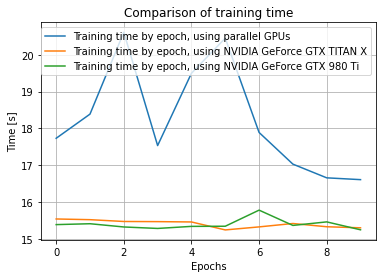

In [22]:
import matplotlib.pyplot as plt

for device_time in all_devices_timing:
    device_name = device_time["device"]
    plt.plot([i for i in range(n_epochs)], device_time["train_time"], label=f"Training time by epoch, using {device_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Time [s]")
    plt.grid()
    plt.title("Comparison of training time")
    plt.legend()